In [62]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [63]:
class Preprocess_Dataframe:

    """ Preprocess input dataframe"""

    def __init__(self, in_df):
        self.in_df = in_df
    
    def remove_all_nans(self, axis_type: str):
        """
        Remove rows or columns containing all NaNs.

        Parameters
        ----------
        axis_type:  str
            'rows' or 'columns'
        """
        if axis_type == 'rows':
            self.in_df = self.in_df.dropna(how = 'all', axis = 0)
        else:
            self.in_df = self.in_df.dropna(how = 'all', axis = 1)
    
    def add_ids(self, id_vals = None):
        """
        Add id column.

        Parameters
        ----------
        in_df:  pd DataFrame
            Dataframe to operate on
        
        """
        if not id_vals:
            self.in_df['id'] = np.arange(1,self.in_df.shape[0]+1)
        else:
            self.in_df['id'] = id_vals 
    
    def rename_cols(self, old_names: list, new_names: list ):
        """
        Renames specified columns using specified new names.

        Parameters
        ----------
        old_names:  list of str
            names of columns to be renamed
        new_names:  list of str
            new column names
        """
        zipped_lists = zip(old_names, new_names)
        names_dict = dict(zipped_lists)
        self.in_df = self.in_df.rename(columns = names_dict)

    def prep_col_names(self, filter_by, suffix, split_by_num = None, suffix_2 = None):
        """
        Prep column names for use of pd.wide_to_long method

        Parameters
        ----------
        filter_by: str
            substring to filter columns by
        suffix: str
            desired suffix
            for wide_to_long conversion
        split_by_num:   
            if supplied, rename Qual
            cols.
            Function only checks if this flag is not None.
            Int, float or str will work well.
            Iterables will result in an error (truth table
            is ambiguous etc)
        """
        cols_to_prep = self.in_df.filter(like = filter_by, axis = 1).columns
        if not split_by_num:
            # NB: reduces flexibility, but can always use method overriding & child class if no longer
            # appropriate.
            prepped_col_names = ['_'.join([name.split()[0],suffix])
                                            for name in cols_to_prep]
            self.rename_cols(cols_to_prep,prepped_col_names)
        else:
            # this just replaces the names from Qual1...Qual6 with what is measured + suffix
            # denoting assessment time point.
            new_names = ['numdays','enjoy','difficult']
            prepped_col_names = ['_'.join([name, suffix]) for name in new_names]
            prepped_col_names.extend(['_'.join([name, suffix_2]) for name in new_names])
            self.rename_cols(cols_to_prep,prepped_col_names)


    def reshape_data(self):
        """
        reshape df from wide to long format

        """
        col_names =  list(set([name.split('_')[0]
                                for name in self.in_df.columns[3:-1]
                                ]))
        self.in_df_long = pd.wide_to_long(self.in_df,
                                            col_names,
                                            i = "id", j = "time", sep = '_'
                                            ).reset_index()
    
    def prepare_df(self):
        """
        Prepare dataframe for analysis.
        Applies above methods to prep dataframe.
        
        """
        # remove cols and rows containing all nans
        for index_name in ['rows','columns']:
            self.remove_all_nans(index_name)
        # add id col
        self.add_ids()
        # rename columns for wide-to-long conversion
        gender_col = self.in_df.filter(like = 'Gender',axis = 1).columns
        self.rename_cols([gender_col[0], 'GHQ'], [gender_col[0].split()[0],'GHQ_0'])
        self.prep_col_names('Qual','1',3,'2')
        for filter_kw, prefix in [('baseline','0'),('day 10','1'),('day 30','2')]:
            self.prep_col_names(filter_kw,prefix)
        self.reshape_data()

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class Data_Explorer:
    """
    Class for initial data exploration.
    """
    def __init__(self, in_df_long,group_col,time_col):
        self.in_df_long = in_df_long
        self.group_col = group_col
        self.time_col = time_col
    
    
    def describe_baseline_continuous(self, var_name):
        """
        Describe the sample at baseline.

        Parameters
        ----------
        var_name:   str
            Name of feature to process
        
        Returns
        -------
        Dataframe summarising bl statistics (for ccontinuous
        features)
        """
        df = self.in_df_long.loc[
                                (self.in_df_long[self.time_col] == 0),
                                [var_name,self.group_col]
                                ].groupby(self.group_col).describe()
        return df
    
    def describe_baseline_categorical(self,var_name: str):
        """
        Describe sample at baseline
        (categorical features)
        
        Parameters
        ----------
        var_name:  str
            name of feature to describe

        """
        # get groups directly from df
        groups = self.in_df_long[self.group_col].unique()
        # for each group, print % of data points in each category
        for group_name in groups:
            df_var = self.in_df_long.loc[(self.in_df_long[self.time_col] == 0)
                                         &(self.in_df_long[self.group_col] == group_name),
                                         [var_name]]
            print(f"\nGroup {group_name}:\n{df_var.apply(lambda x: (x.value_counts())/len(x))*100}")
    
    def describe_bl(self, var_names_cont: list, var_names_cat: list):
        """
        Describe sample at baseline
        Prints results to screen.

        Parameters
        ----------
        var_names_cont:  list of str
            names of continuous features to describe
        var_names_cat:  list of str
            names of categorical features to describe
        """
        for var in var_names_cont:
            df = self.describe_baseline_continuous(var)
            print(f"\n{df}")
        for var in var_names_cat:
            self.describe_baseline_categorical(var)

    
    def get_baseline_diffs(self, var_name):
        """
        Test for baseline differences.

        Parameters
        ----------
        var_name: str
            name of column to perform test on
        
        Returns
            statistic and p-value
        """
        _, norm_pval = stats.normaltest(self.in_df_long.loc[:,var_name])
        if norm_pval<0.05:
            non_parametric = 1
            print(f"Feature {var_name} is not normally distributed.\nUsing Mann Whitney U test.")
        else:
            non_parametric = None

        group_names = self.in_df_long[self.group_col].unique()
        samp1 = self.in_df_long.loc[(self.in_df_long[self.group_col] == group_names[0])
                                    &(self.in_df_long[self.time_col] == 0),var_name]
        samp2 = self.in_df_long.loc[(self.in_df_long[self.group_col] == group_names[1])
                                    &(self.in_df_long[self.time_col] == 0),var_name]

        if not non_parametric:
            stat,p_val = stats.ttest_ind(samp1, samp2, nan_policy = 'omit')
        else:
            stat,p_val = stats.mannwhitneyu(samp1, samp2)
        
        if p_val<0.05:
            print(f"\nGroups differ significantly at baseline on feature {var_name} (pval: {p_val}).")
        else:
            print(f"\nNo significant baseline differences detected on feature {var_name} (pval:{p_val}).")
        return stat, p_val
    
    def describe_sample(self, var_names_cont: list,var_names_cat: list):
        """
        Describe sample at baseline.
        """
        self.describe_bl(var_names_cont, var_names_cat)
        for var in var_names_cont:
            self.get_baseline_diffs(var)
    
    def visualize_dist(self, var_name: str, distribution = None):
        """
        shows qq plot of var_name against
        either gamma or gaussian dist

        Parameters
        ----------
        var_name:   str
            feature to plot
        distribution:
            if supplied, will plot against gamma
            instead of Gaussian.
            Recommend float, str or int as flag.
            (Function only checks if flag is not None)
        """
        if not distribution:
            fig = sm.qqplot(self.in_df_long.loc[:,var_name],line = 'q')
            fig.show()
        else:
            distribution = distribution
            fig = sm.qqplot(self.in_df_long.loc[:,var_name],dist = stats.gamma,distargs = (4,),line = 'q')
            fig.show()



In [65]:
from statsmodels.graphics.factorplots import interaction_plot

class Data_Visualizer(Data_Explorer):

    """ Class for data visualization """

    def __init__(self,in_df_long,group_col,time_col):
        super().__init__(in_df_long, group_col, time_col)

    def draw_kdeplot(self,ax_name, group_name, var_name: str):
        """
        Visualize univariate distributions.
        Uses Seaborn KDE plots.
        Hue = assessment time point.

        Parameters
        ----------
        ax_name:    int
            axis to plot on (for subplots)
        group_name: str
            group to plot for
        var_name:   str
            feature to plot
        
        Draws KDE plot using seaborn.
        """
        df = self.in_df_long.loc[
                                (self.in_df_long[self.group_col] == group_name),
                                var_name
                                ]
        fig = sns.kdeplot(
                        df, fill = True,
                            hue = self.in_df_long[self.time_col],
                            palette = 'crest', hue_order = ['0','1','2'],
                            ax = ax_name,
                            legend = True,
                            #warn_singular = False
                            )
    
           
    def plot_bivariate(self, ax_name,var_names: list, plot_type:str, hue:str):
        """
        Draw scatter or swarm plot.
        
        Parameters
        ----------
        ax_name:    int
            axis to plot on (for subplots)
        var_names:  list
            names of features to plot [x, y]
        plot_type:  str
            if 'scatter', plot scatter plot
            else, plot swarm plot
        
        hue:    str
            name of column to use for hue parameter
            (here, will typically be time)

        """
        if plot_type == 'scatter':
            fig = sns.scatterplot(x = var_names[0],
                                    y = var_names[1],
                                    hue = self.in_df_long[hue],
                                    data = self.in_df_long,
                                    ax = ax_name)
        else:
            fig = sns.swarmplot(x = var_names[0],
                                y = var_names[1],
                                hue = self.in_df_long[hue],
                                data = self.in_df_long,
                                ax = ax_name)
    
    
    def draw_mean_trajectories(self,var_name: str):
        """
        Draw mean trajectories for feature var_name.
        
        Parameters
        ----------
        var_name:   str
            feature to plot
        """
        fig_mean, ax = plt.subplots(figsize=(6, 6))
        fig_mean = interaction_plot(
                                    x=self.in_df_long[self.time_col],
                                    trace=self.in_df_long[self.group_col],
                                    response=self.in_df_long[var_name],
                                    colors=["blue","black"],
                                    markers=[ "^",'x'],
                                    ms=10,
                                    ax=ax,
                                    )
        
        


In [66]:
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler

class Data_Analyzer(Data_Explorer):
    """ Class for data analysis"""

    def __init__(self, in_df_long,group_col,time_col,id_col,oc_name):
        super().__init__(in_df_long, group_col, time_col)
        self.id_col = id_col
        self.oc_name = oc_name
    
    def scale_scores(self, col_names: list, scaler_type: str):
        """ 
        Scale questionnaire scores.

        Parameters
        ----------
        in_df:  pandas Dataframe
            Dataframe to operate on.
        col_names:  list of str
            names of features to scale
        scaler_type:    str
            if 'robust', use robust scaler
            else, use standard scaler.

        """
        if scaler_type == 'robust':
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()

        for col in col_names:
            self.in_df_long[col+'_scaled'] = scaler.fit_transform(self.in_df_long[col].values.reshape(-1,1))
    
    def get_corr(self, feat_names: list, method_name, use_time = None):
        """
        Get correlation for feat_names
        features.
        Prints correlation matrix to screen.

        Parameters
        ----------
        qual_names: list of str
            names of qualitative variables
        method_name: str
            method for pd.corr() function
            ('pearson','kendall','spearman')
        use_time:
            if supplied, calculate correlation
            for each measurement time point
        """
        if not use_time:
            df = self.in_df_long.loc[self.in_df_long[self.time_col]>0,feat_names]
            print(df.corr(method = method_name))
        else:
            for time in self.in_df_long[self.time_col].unique():
                df = self.in_df_long.loc[self.in_df_long[self.time_col]==time,feat_names]
                print(df.corr(method = method_name))            

    def remove_excess_missing(self,criterion = None):
        """
        Remove records with too many missing values.

        Parameters
        ----------
        criterion:  array-like
            if supplied, checks for NaNs
            at the specified measurement
            time points only.
 
        """
        if not criterion:
            criterion = [0,1,2]

        rem_inds = []
        for id_name in self.in_df_long[self.id_col].unique():
            df= self.in_df_long.loc[(self.in_df_long.id==id_name)&(self.in_df_long[self.time_col].isin(criterion)),self.oc_name]
            if not df.any():
                inds = df.index.values
                rem_inds.extend(inds)
            else:
                continue
        self.in_df_long = self.in_df_long.drop(labels = rem_inds, axis = 0)


    def build_lmem(self, oc_name: str, predictor_names:list, interacts = None, r_slpe = None):
        """
        Use linear mixed effects model for analysis.
    
        Parameters
        ----------
        oc_name:    str
            outcome column name
        predictor_names:    list of str
            list of column names to use as predictors
        interacts:  
            Flag to indicate whether to construct the formula
            using interactions ( pred1*pred2) or not.
            Any value is fine, as the code only checks whether
            this is None or not.
        """
        if not interacts:
            rh_side = '+'.join(predictor_names)
        else:
            rh_side = '*'.join(predictor_names)
        self.formula = ''.join([oc_name,'~',rh_side])
        if not r_slpe: 
            self.model_lmem = smf.mixedlm(self.formula, self.in_df_long,
                                        groups=self.id_col,missing = 'drop').fit()
        else:
            self.model_lmem = smf.mixedlm(self.formula, self.in_df_long, groups=self.id_col, 
                                    re_formula = ''.join(['~',r_slpe]),missing = 'drop').fit()
        print(f"\nModel results:\n{self.model_lmem.summary()}")
    
    def build_gee(self, oc_name:str, predictor_names:list, fam, cov_type, interacts = None):
        """
        Use GEE approach for analysis.
        
        Parameters
        ----------
        oc_name:    str
            outcome column name
        predictor_names:    list of str
            list of column names to use as predictors
        interacts:  
            Flag to indicate whether to construct the formula
            using interactions ( pred1*pred2) or not.
            Any value is fine, as the code only checks whether
            this is None or not.
        fam:
            Mean response structure to use
        cov_type:
            covariance structure to use
        """
        if not interacts:
            rh_side = '+'.join(predictor_names)
        else:
            rh_side = '*'.join(predictor_names)
        self.formula = ''.join([oc_name,'~',rh_side])
        try:
            self.model_gee = smf.gee(self.formula,self.id_col, self.in_df_long,
                            cov_struct = cov_type, family = fam,
                            missing = 'drop').fit()
        except ValueError:
            warnings.warn("Covariance structure changed to Independence.",
                            category = UserWarning)
            self.model_gee = smf.gee(self.formula,self.id_col, self.in_df_long,
                            cov_struct = sm.cov_struct.Independence(),
                            family = fam,
                            missing = 'drop').fit()
        print(self.model_gee.summary2())
    
    def visualize_dist(self, var_name: str):
        """
        QQ plots for resids

        var_name: str
            name of var holding residuals
        """
        fig = sm.qqplot(var_name,line = 'q')
        fig.show()
    
    def model_diagnostics(self, model_type):
        """
        Model diagnostics

        Parameters
        ----------

        -------
        """
        if model_type == 'lmem':
            model_to_use = self.model_lmem
            # get residuals
            resids = model_to_use.resid
            # draw QQ plot (resids against normal)
            self.visualize_dist(resids)
        else:
            model_to_use = self.model_gee
            # get deviance residuals
            resids = model_to_use.resid_deviance
            # sort resids for halfnorm plots
            a = resids
            a.sort()
            fig = plt.figure()
            # use halfnorm plots for gee resids
            res = stats.probplot(a,dist = stats.halfnorm,
                                sparams = (-0.18,10), plot=plt)
            
        mod_dict = {'residuals': resids,'fitted': model_to_use.fittedvalues}
        res_df = pd.DataFrame(data = mod_dict)
        # fitted against residuals
        g = sns.lmplot(x = "fitted", y = "residuals",
                        #hue = self.group_col,
                        data = res_df)
        g = (g.set_axis_labels("Fitted values", "Residuals"))

In [67]:
# input directory path/input filename
input_dir = os.getcwd()
infilename = "data.csv"
# read input data file
in_df = pd.read_csv(os.path.join(input_dir, infilename))

In [68]:
# Main. Start by preprocessing dataframe.
pp = Preprocess_Dataframe(in_df)
pp.prepare_df()
# Get baseline description
de = Data_Explorer(pp.in_df_long,'Group','time')
de.describe_sample(['GHQ','SWLS','PSS','RWS','Age'],['Gender'])


        GHQ                                                
      count      mean       std  min   25%  50%   75%   max
Group                                                      
A      38.0  3.578947  2.853462  0.0  1.00  3.5  5.75   9.0
B      36.0  3.388889  3.227363  0.0  0.75  3.0  5.00  10.0

       SWLS                                                   
      count       mean       std   min   25%   50%   75%   max
Group                                                         
A      38.0  24.184211  5.727389  10.0  21.0  25.0  28.0  35.0
B      34.0  24.617647  5.482837  11.0  21.0  27.0  28.0  33.0

        PSS                                                   
      count       mean       std  min   25%   50%    75%   max
Group                                                         
A      38.0  16.684211  5.251024  5.0  14.0  16.0  19.75  28.0
B      34.0  17.794118  5.563841  6.0  13.0  18.5  21.75  28.0

        RWS                                                      


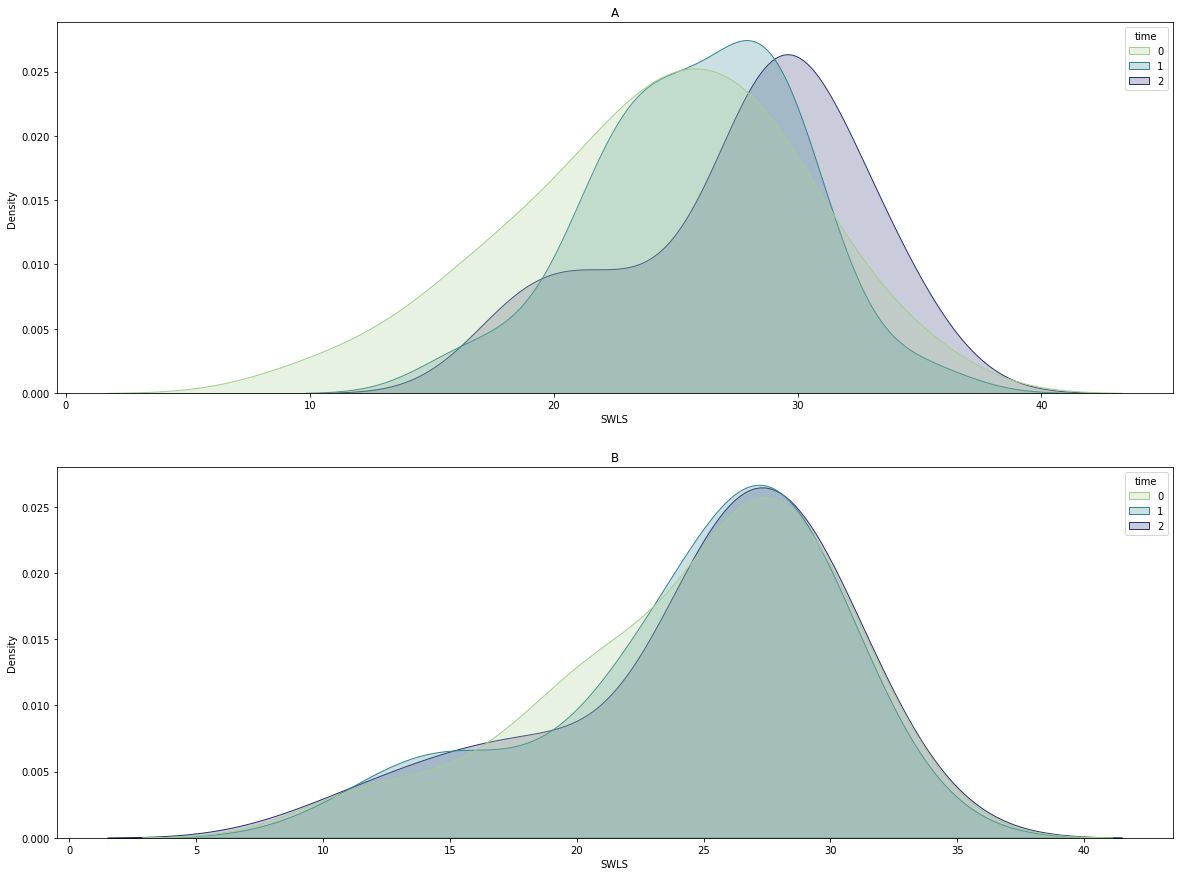

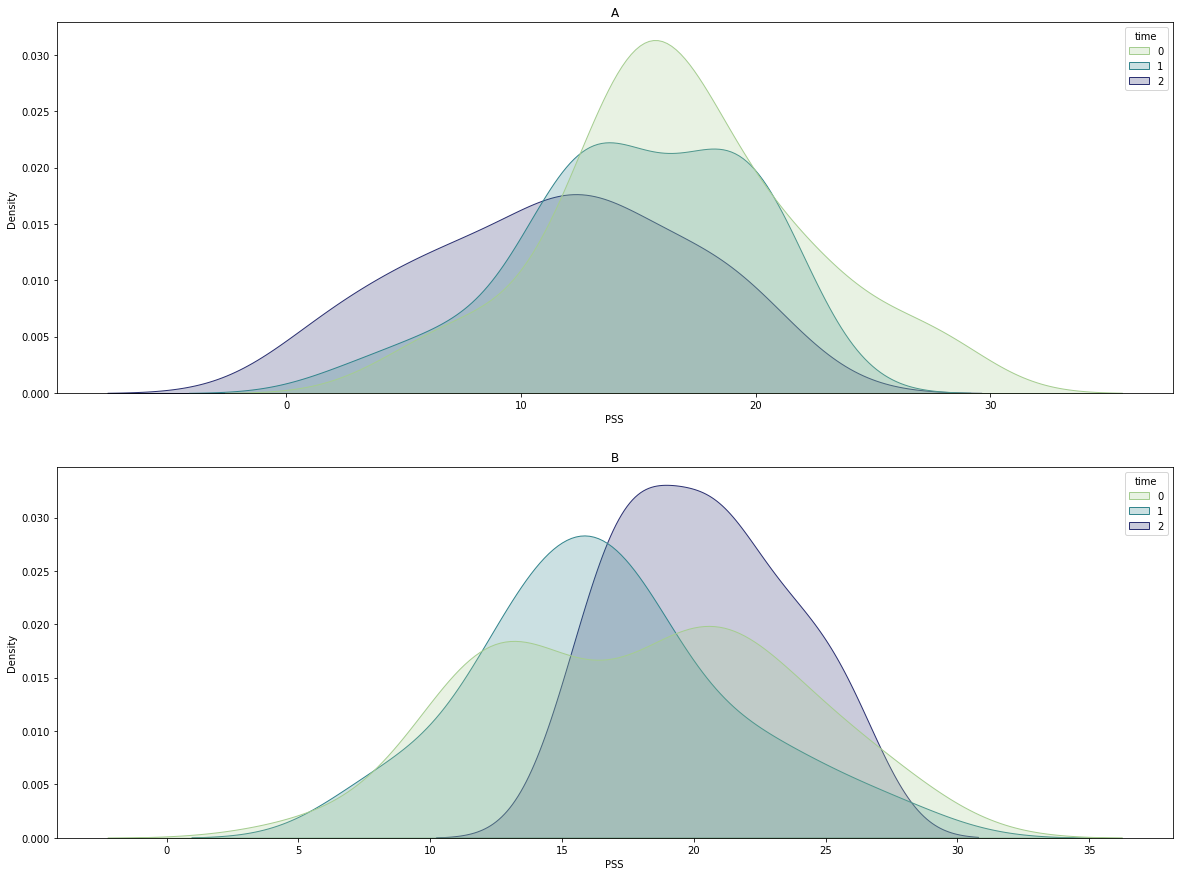

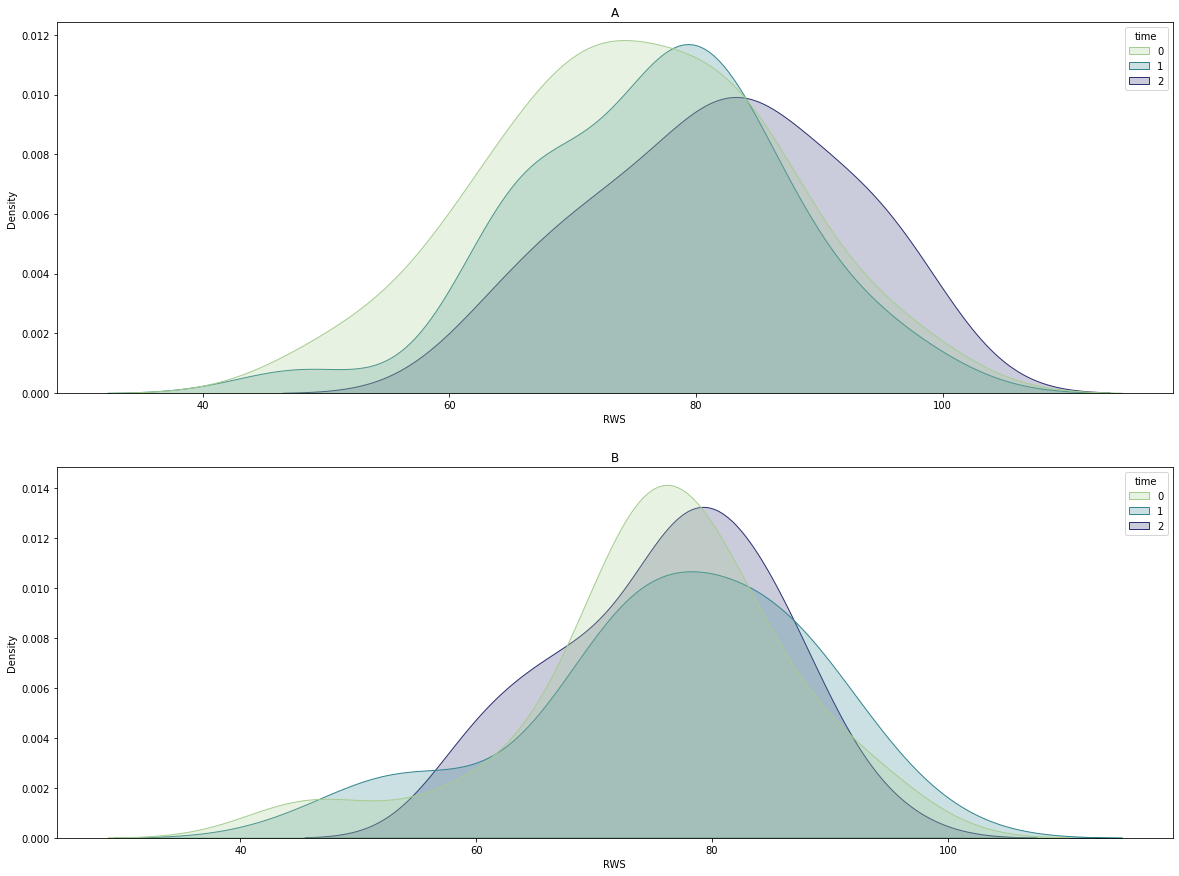

In [69]:
dv = Data_Visualizer(pp.in_df_long,'Group','time')
vars = ['SWLS','PSS','RWS']
groups = pp.in_df_long.Group.unique()

for var in vars:
    #dv.draw_mean_trajectories(var)
    fig,ax = plt.subplots(len(groups),1,figsize = (20,15))
    for num,group_name in enumerate(groups):
        dv.draw_kdeplot(ax[num], group_name,var)
        ax[num].title.set_text(group_name)

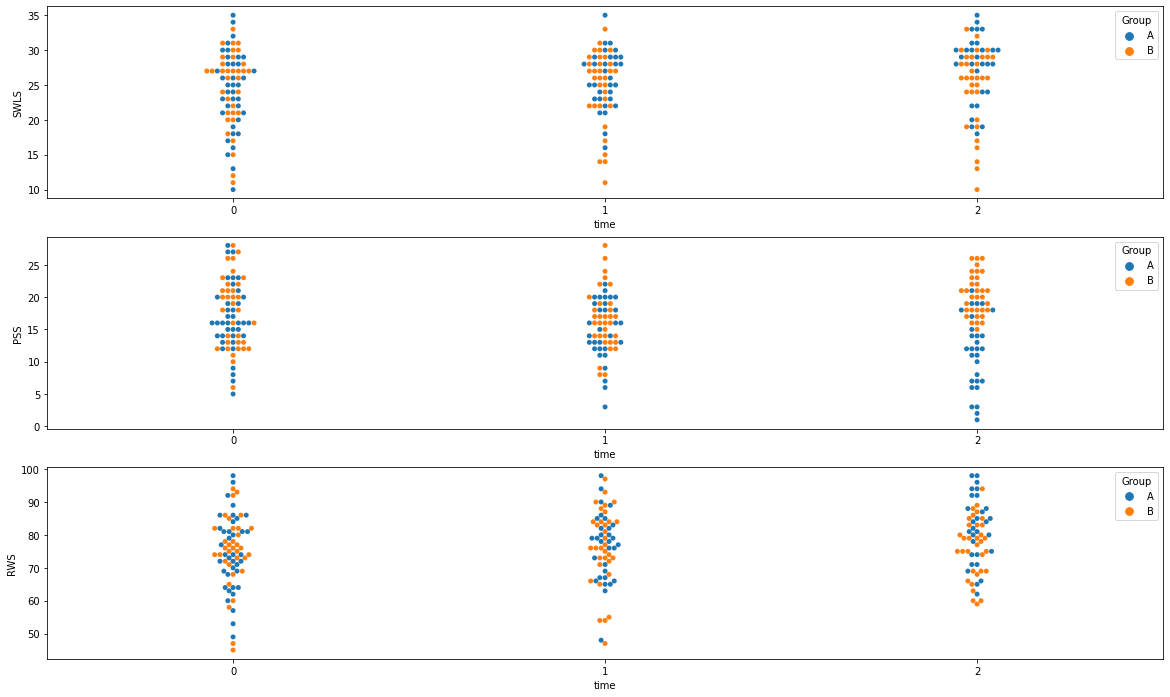

In [70]:
fig,ax = plt.subplots(len(vars),1,figsize = (20,12))
for i, var in enumerate(vars):
    dv.plot_bivariate(ax[i],['time',var],'swarm', 'Group')


Building model...

Model results:
                               Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               SWLS     
No. Observations:                 198                   Method:                           REML     
No. Groups:                       72                    Scale:                            6.6039   
Min. group size:                  1                     Log-Likelihood:                   -554.5598
Max. group size:                  3                     Converged:                        Yes      
Mean group size:                  2.8                                                              
---------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------

<ipython-input-66-1f191b75b1f5>:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Building model...

Model results:
                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                PSS      
No. Observations:                198                    Method:                            REML     
No. Groups:                      72                     Scale:                             8.3824   
Min. group size:                 1                      Log-Likelihood:                    -566.7706
Max. group size:                 3                      Converged:                         Yes      
Mean group size:                 2.8                                                                
----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------------------

<ipython-input-66-1f191b75b1f5>:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Model results:
                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                RWS      
No. Observations:                198                    Method:                            REML     
No. Groups:                      72                     Scale:                             18.7372  
Min. group size:                 1                      Log-Likelihood:                    -681.1274
Max. group size:                 3                      Converged:                         Yes      
Mean group size:                 2.8                                                                
----------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------
Interc

<ipython-input-66-1f191b75b1f5>:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


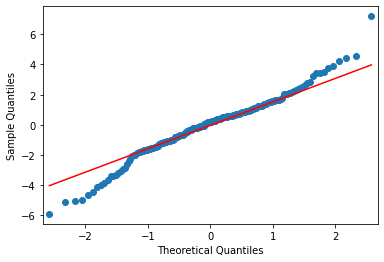

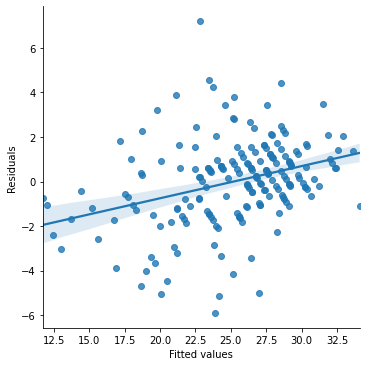

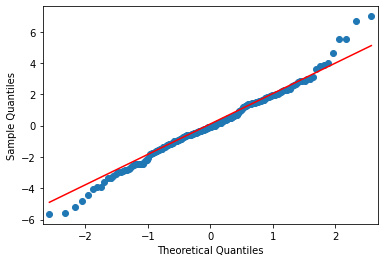

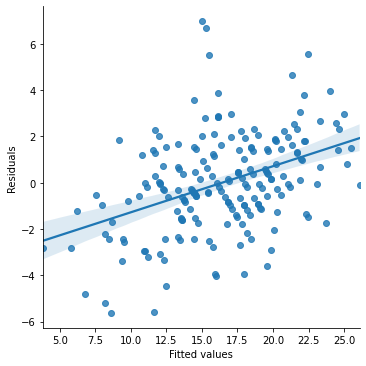

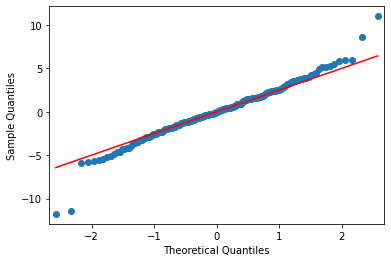

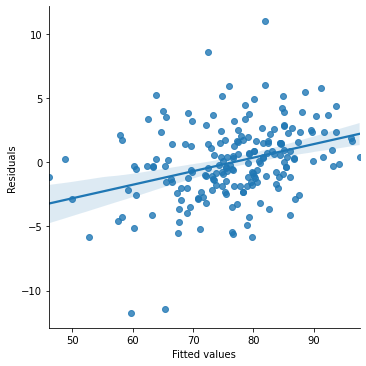

In [71]:

for var in vars:
    da = Data_Analyzer(pp.in_df_long,'Group','time','id',var)
    da.remove_excess_missing()
    da.remove_excess_missing(criterion = [1,2])
    print("\nBuilding model...")
    da.build_lmem(var,["C(Group,Treatment('B'))", "C(time,Treatment(0))"],interacts = 1,r_slpe = "time")
    da.model_diagnostics('lmem')
    #da.build_gee(var,["C(Group,Treatment('B'))", "C(time,Treatment(0))"],sm.families.Tweedie(), sm.cov_struct.Autoregressive(),interacts = 1)
    #da.model_diagnostics('gee')

Exploratory section.

C:\Users\luzia.troebinger\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)



Now printing correlation between features ['SWLS', 'PSS', 'RWS']
          SWLS       PSS       RWS
SWLS  1.000000 -0.383569  0.510019
PSS  -0.383569  1.000000 -0.323840
RWS   0.510019 -0.323840  1.000000
          SWLS       PSS       RWS
SWLS  1.000000 -0.406751  0.514314
PSS  -0.406751  1.000000 -0.441679
RWS   0.514314 -0.441679  1.000000
          SWLS       PSS       RWS
SWLS  1.000000 -0.531989  0.622858
PSS  -0.531989  1.000000 -0.443840
RWS   0.622858 -0.443840  1.000000

Now printing correlation between qual features:
           enjoy  numdays  difficult
enjoy        NaN      NaN        NaN
numdays      NaN      NaN        NaN
difficult    NaN      NaN        NaN
              enjoy   numdays  difficult
enjoy      1.000000  0.128479   0.415040
numdays    0.128479  1.000000   0.348311
difficult  0.415040  0.348311   1.000000
              enjoy   numdays  difficult
enjoy      1.000000  0.374757   0.610046
numdays    0.374757  1.000000   0.688251
difficult  0.610046  0.688251 

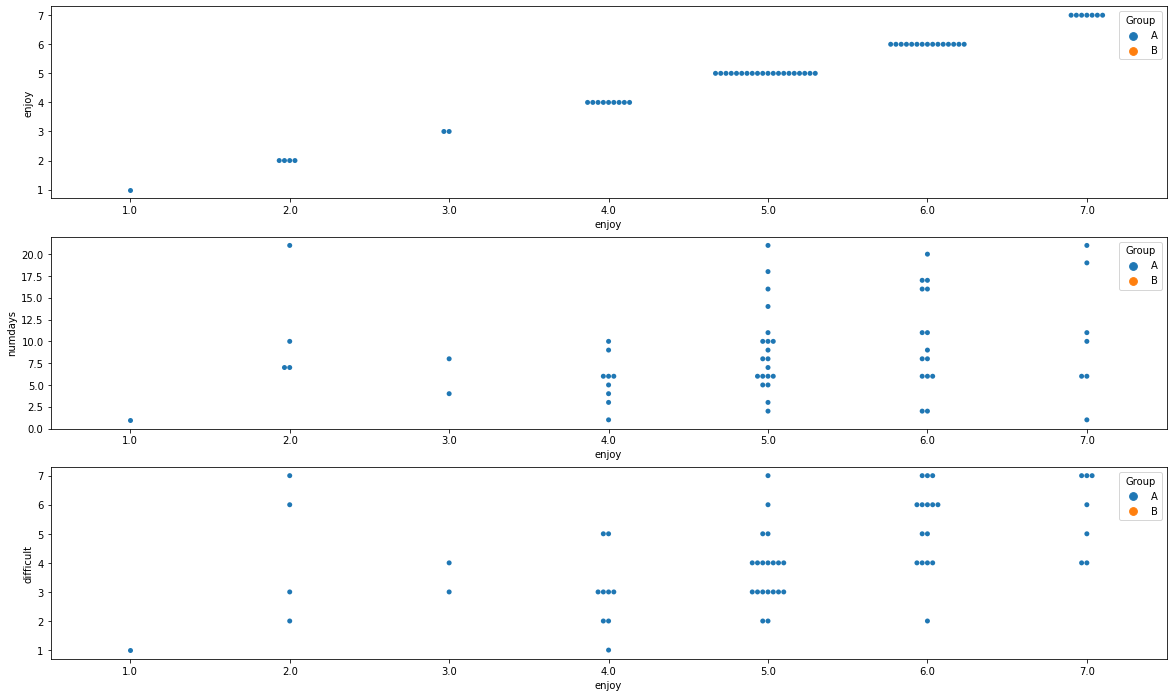

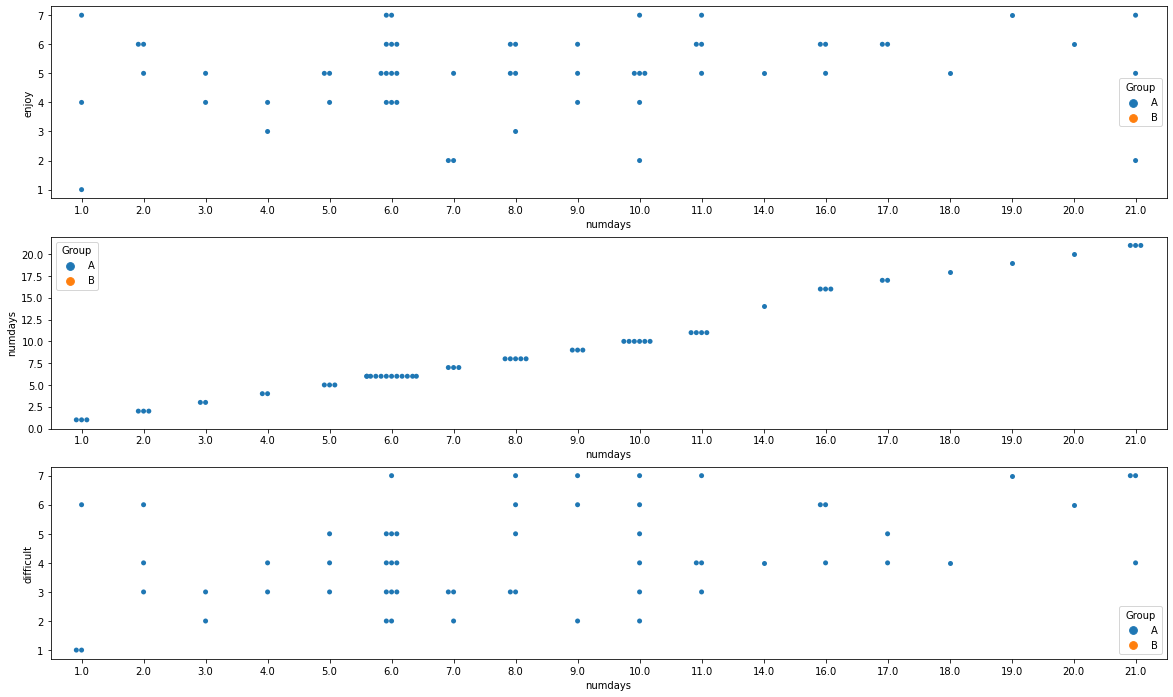

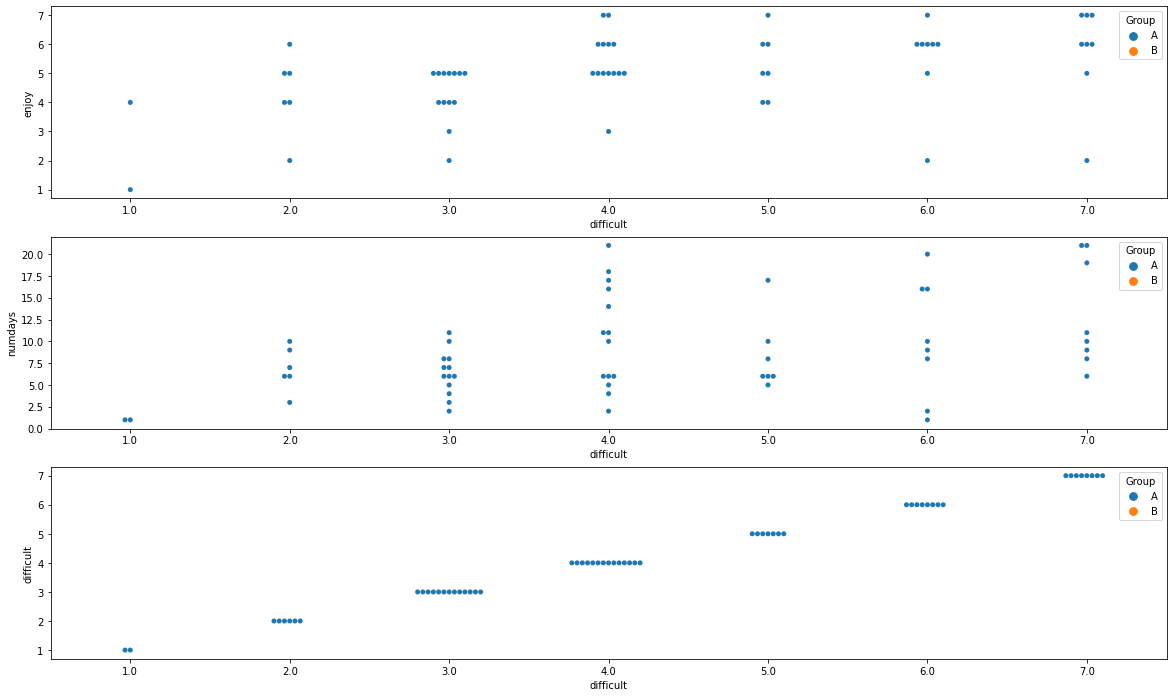

In [72]:
qual_vars = ['enjoy','numdays','difficult']
for qual1 in qual_vars:
    fig,ax = plt.subplots(3,figsize = (20,12))
    for i,qual_var in enumerate(qual_vars):
        dv.plot_bivariate(ax[i],[qual1,qual_var],'swarm', 'Group')

print(f"\nNow printing correlation between features {vars}")
da.get_corr(vars,'spearman',1)
print(f"\nNow printing correlation between qual features:")
da.get_corr(qual_vars,'spearman',1)